In [1]:
import os
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta, datetime
from tqdm import tqdm

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Accuracy of models throughout leadtimes

In [2]:
# load paths dates and target indices
ta_path = '/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/{y:04}{m:02}{d:02}{h:02}{min:02}.h5'
lc_path = '/data/softec-lagrangian-nowcasting/outputs/lagrangian/lcnn-bugfix_v2/lcnn-bugfix.h5'
nn_path = '/data/softec-lagrangian-nowcasting/outputs/RainNet/RainNet-iterative.h5'
euclid_path = '/data/softec-lagrangian-nowcasting/outputs/Euclid/Euclid.h5'
lupin_path = '/data/softec-lagrangian-nowcasting/outputs/LUPIN-ECAI/LUPIN-ECAI.h5'

with h5py.File('/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/metadata.h5', 'r') as hf:
    date_list = [item.decode() for item in hf['timestamps'][()]]
    date_list = np.array([datetime.strptime(item, '%Y-%m-%dT%H:%M:%S.%fZ') for item in date_list])
with h5py.File('/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/metadata_lcnn_test.h5', 'r') as hf:
    targets = np.array(hf['target_idx'])
targets = targets[12:len(targets)]

/tmp/ipykernel_3619594/4240039072.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  targets = np.array(hf['target_idx'])


In [3]:
def arr_reconstruct_uint8(
    uint8_array: np.ndarray, missing_val: np.uint8 = 255, undetect_val: np.uint8 = 0, mask_val: float = np.nan, mask2_val: float = 64.0
):
    mask = uint8_array == missing_val
    mask2 = uint8_array == undetect_val
    arr = uint8_array.astype(np.float64)
    arr[mask] = mask_val
    arr[mask2] = mask2_val
    arr = (arr - 64) / 2.0
    return arr

def dbztommh(data):
    data = 10 ** (data * 0.1)
    data = (data / 200) ** (1 / 1.6)
    return data

In [4]:
# camfulate MAE and ME and MSE
leadtimes = range(6)

def MSE(A, B):
    return np.nanmean((A - B)**2, axis=None)
def MAE(A, B):
    return np.nanmean(np.abs(A - B), axis=None)
def ME(A, B):
    return np.nanmean(A - B, axis=None)

with h5py.File(lc_path, 'r') as lf, h5py.File(nn_path, 'r') as nf, h5py.File(lupin_path, 'r') as lupin, h5py.File(euclid_path, 'r') as euclid:    
    
    eval_list = [lf, nf, lupin, euclid]

    tot_MAE = np.zeros((len(eval_list),len(targets),6), dtype=np.float64)
    tot_ME = np.zeros((len(eval_list),len(targets),6), dtype=np.float64)
    tot_MSE = np.zeros((len(eval_list),len(targets),6), dtype=np.float64)
    
    for i, idx in enumerate(tqdm(targets, total=len(targets))):
        date = date_list[idx]
        date_lagged = date - timedelta(minutes=30)

        groups = []

        for file in eval_list:
            groups.append(file.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S')).require_group('model'))
        
        for leadtime in leadtimes:
            target_date_lagged = date - timedelta(minutes=25-leadtime*5)
            target = h5py.File(ta_path.format(y=target_date_lagged.year, m=target_date_lagged.month, d=target_date_lagged.day, h=target_date_lagged.hour, min=target_date_lagged.minute), 'r')['precipitation_map']
            target = target[2:338,2:338][45:291, 45:291]
            target = dbztommh(target)

            for j, group in enumerate(groups):
                data = group.require_group(str(leadtime+1))['data'][()]
                output = arr_reconstruct_uint8(data)
                output_center_cut = output[45:291, 45:291]
                output_center_cut = dbztommh(output_center_cut)
                
                tot_MAE[j, i, leadtime] = MAE(target, output_center_cut)
                tot_ME[j, i, leadtime] = ME(target, output_center_cut)
                tot_MSE[j, i, leadtime] = MSE(target, output_center_cut)

100%|██████████| 10944/10944 [16:32<00:00, 11.02it/s]


In [5]:
MAE = {}
ME = {}
MSE = {}

idx = 0
MAE['L-CNN'] = np.mean(tot_MAE[idx], axis=0)
ME['L-CNN'] = np.mean(tot_ME[idx], axis=0)
MSE['L-CNN'] = np.mean(tot_MSE[idx], axis=0)

idx = 1
MAE['RainNet'] = np.mean(tot_MAE[idx], axis=0)
ME['RainNet'] = np.mean(tot_ME[idx], axis=0)
MSE['RainNet'] = np.mean(tot_MSE[idx], axis=0)

idx = 2
MAE['LUPIN'] = np.mean(tot_MAE[idx], axis=0)
ME['LUPIN'] = np.mean(tot_ME[idx], axis=0)
MSE['LUPIN'] = np.mean(tot_MSE[idx], axis=0)

idx = 3
MAE['EuclidP'] = np.mean(tot_MAE[idx], axis=0)
ME['EuclidP'] = np.mean(tot_ME[idx], axis=0)
MSE['EuclidP'] = np.mean(tot_MSE[idx], axis=0)

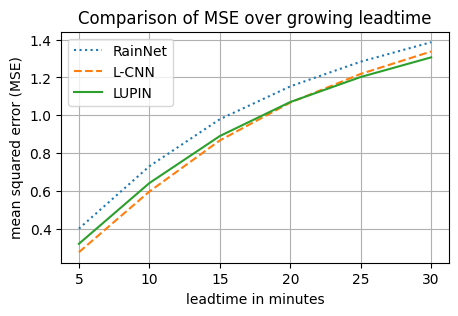

In [6]:
# MSE plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, MSE['RainNet'], ':', label='RainNet')
plt.plot(x, MSE['L-CNN'], '--', label='L-CNN')
plt.plot(x, MSE['LUPIN'], label='LUPIN')

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean squared error (MSE)")
plt.title('Comparison of MSE over growing leadtime')
plt.legend(loc="upper left")
# plt.yscale('log')
plt.savefig("mse.pdf", bbox_inches='tight')

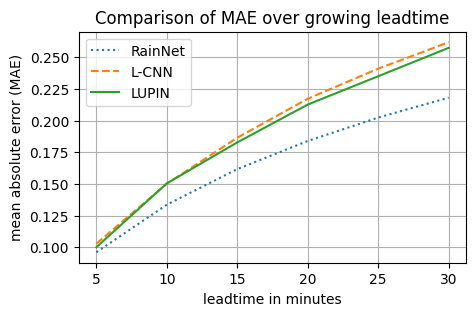

In [7]:
# MSE plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, MAE['RainNet'], ':', label='RainNet')
plt.plot(x, MAE['L-CNN'], '--', label='L-CNN')
plt.plot(x, MAE['LUPIN'], label='LUPIN')

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean absolute error (MAE)")
plt.title('Comparison of MAE over growing leadtime')
plt.legend(loc="upper left")
# plt.yscale('log')
plt.savefig("mae.pdf", bbox_inches='tight')

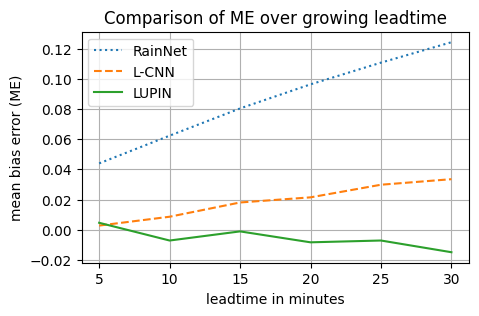

In [8]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, ME['RainNet'], ':', label='RainNet')
plt.plot(x, ME['L-CNN'], '--', label='L-CNN')
plt.plot(x, ME['LUPIN'], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean bias error (ME)")
plt.title('Comparison of ME over growing leadtime')
plt.legend(loc="upper left")
plt.savefig("me.pdf", bbox_inches='tight')

In [9]:
# calculate elements of confusion matrix
leadtimes = range(6)
thresholds = [1, 5, 10]

def get_conf_mat(pred, target, threshold):
    pred_mask = pred.flatten() > threshold
    target_mask = target.flatten() > threshold
    tn, fp, fn, tp = np.bincount(target_mask*2 + pred_mask, minlength=4)
    return tn, fp, fn, tp

def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    return precision, recall, accuracy, ets, far

with h5py.File(lc_path, 'r') as lf, h5py.File(nn_path, 'r') as nf, h5py.File(lupin_path, 'r') as lupin, h5py.File(euclid_path, 'r') as euclid:

    eval_list = [lf, nf, lupin, euclid]

    tot_tn = np.zeros((len(eval_list),len(thresholds),6), dtype=np.float64)
    tot_fp = np.zeros((len(eval_list),len(thresholds),6), dtype=np.float64)
    tot_fn = np.zeros((len(eval_list),len(thresholds),6), dtype=np.float64)
    tot_tp = np.zeros((len(eval_list),len(thresholds),6), dtype=np.float64)

    for i, idx in enumerate(tqdm(targets, total=len(targets))):
        date = date_list[idx]
        date_lagged = date - timedelta(minutes=30)

        groups = []

        for file in eval_list:
            groups.append(file.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S')).require_group('model'))

        for leadtime in leadtimes:
            target_date_lagged = date - timedelta(minutes=25-leadtime*5)
            target = h5py.File(ta_path.format(y=target_date_lagged.year, m=target_date_lagged.month, d=target_date_lagged.day, h=target_date_lagged.hour, min=target_date_lagged.minute), 'r')['precipitation_map']
            target = target[2:338,2:338][45:291, 45:291]
            target = dbztommh(target)

            for j, group in enumerate(groups):
                data = group.require_group(str(leadtime+1))['data'][()]
                output = arr_reconstruct_uint8(data)
                output_center_cut = output[45:291, 45:291]
                output_center_cut = dbztommh(output_center_cut)
            
                for k, threshold in enumerate(thresholds):
                    tn, fp, fn, tp = get_conf_mat(output_center_cut, target, threshold)
                    tot_tn[j, k, leadtime] += tn
                    tot_fp[j, k, leadtime] += fp
                    tot_fn[j, k, leadtime] += fn
                    tot_tp[j, k, leadtime] += tp

100%|██████████| 10944/10944 [19:31<00:00,  9.35it/s]


In [10]:
def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    csi = tp / (tp + fn + fp)
    return precision, recall, accuracy, ets, far, csi  

precision = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)
recall = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)
accuracy = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)
ets = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)
far = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)
csi = np.zeros((len(eval_list), len(thresholds), 6), dtype=np.float64)

for i in range(len(eval_list)):
    for j in range(len(thresholds)):
        for k in range(len(leadtimes)):
            precision[i, j, k], recall[i, j, k], accuracy[i, j, k], ets[i, j, k], far[i, j, k], csi[i, j, k] = get_disc_metrics(tot_tn[i, j, k], tot_fp[i, j, k], tot_fn[i, j, k], tot_tp[i, j, k])

In [11]:
precision_dict = {}
recall_dict = {}
accuracy_dict = {}
ets_dict = {}
far_dict = {}
csi_dict = {}

idx = 0
precision_dict['L-CNN'] = precision[idx][-1]
recall_dict['L-CNN'] = recall[idx][-1]
accuracy_dict['L-CNN'] = accuracy[idx][-1]
ets_dict['L-CNN'] = ets[idx][-1]
far_dict['L-CNN'] = far[idx][-1]
csi_dict['L-CNN'] = csi[idx][-1]

idx = 1
precision_dict['RainNet'] = precision[idx][-1]
recall_dict['RainNet'] = recall[idx][-1]
accuracy_dict['RainNet'] = accuracy[idx][-1]
ets_dict['RainNet'] = ets[idx][-1]
far_dict['RainNet'] = far[idx][-1]
csi_dict['RainNet'] = csi[idx][-1]

idx = 2
precision_dict['LUPIN'] = precision[idx][-1]
recall_dict['LUPIN'] = recall[idx][-1]
accuracy_dict['LUPIN'] = accuracy[idx][-1]
ets_dict['LUPIN'] = ets[idx][-1]
far_dict['LUPIN'] = far[idx][-1]
csi_dict['LUPIN'] = csi[idx][-1]

idx = 3
precision_dict['EuclidP'] = precision[idx][-1]
recall_dict['EuclidP'] = recall[idx][-1]
accuracy_dict['EuclidP'] = accuracy[idx][-1]
ets_dict['EuclidP'] = ets[idx][-1]
far_dict['EuclidP'] = far[idx][-1]
csi_dict['EuclidP'] = csi[idx][-1]

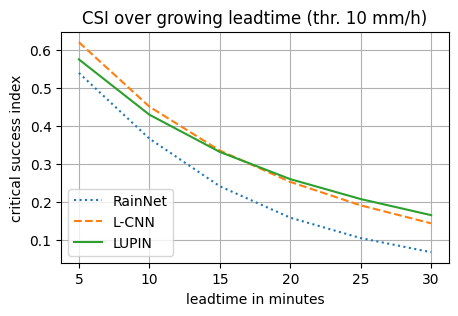

In [74]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, csi_dict['RainNet'], ':', label='RainNet')
plt.plot(x, csi_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, csi_dict['LUPIN'], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("critical success index")
plt.title('CSI over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("csi.pdf", bbox_inches='tight')

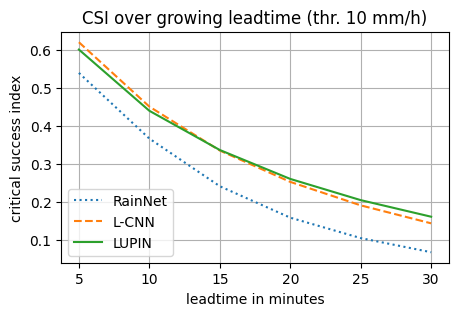

In [12]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, csi_dict['RainNet'], ':', label='RainNet')
plt.plot(x, csi_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, csi_dict['LUPIN'], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("critical success index")
plt.title('CSI over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("csi.pdf", bbox_inches='tight')

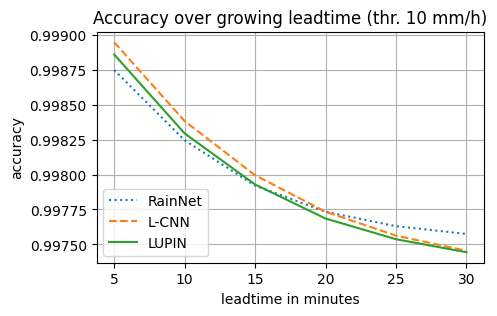

In [14]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, accuracy_dict['RainNet'], ':', label='RainNet')
plt.plot(x, accuracy_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, accuracy_dict['LUPIN'], label='LUPIN')
#plt.plot(x, accuracy_dict['EuclidP'], label='EuclidP')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("accuracy")
plt.title('Accuracy over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("accuracy.pdf", bbox_inches='tight')

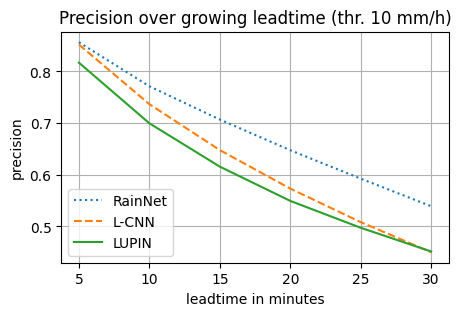

In [22]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, precision_dict['RainNet'], ':', label='RainNet')
plt.plot(x, precision_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, precision_dict['LUPIN'], label='LUPIN')
#plt.plot(x, precision_dict['EuclidP'], label='EuclidP')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("precision")
plt.title('Precision over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("precision.pdf", bbox_inches='tight')

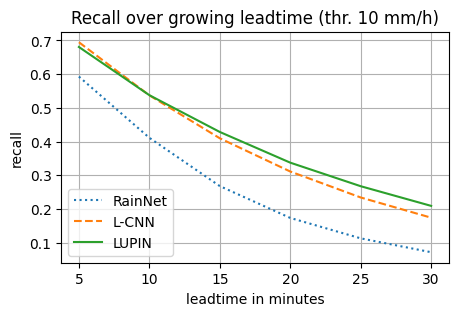

In [66]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, recall_nn[2], ':', label='RainNet')
plt.plot(x, recall_lc[2], '--', label='L-CNN')
plt.plot(x, recall_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("recall")
plt.title('Recall over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("recall.pdf", bbox_inches='tight')

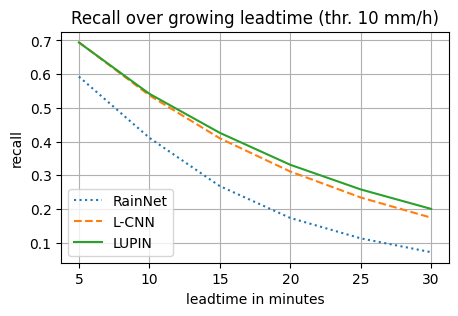

In [21]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, recall_dict['RainNet'], ':', label='RainNet')
plt.plot(x, recall_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, recall_dict['LUPIN'], label='LUPIN')
#plt.plot(x, recall_dict['EuclidP'], label='EuclidP')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("recall")
plt.title('Recall over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("recall.pdf", bbox_inches='tight')

In [25]:
(recall_dict['LUPIN'][-1] / recall_dict['L-CNN'][-1] - 1) * 100

14.895089585231315

In [24]:
(ets_dict['LUPIN'][-1] / ets_dict['L-CNN'][-1] - 1) * 100

12.103644522488487

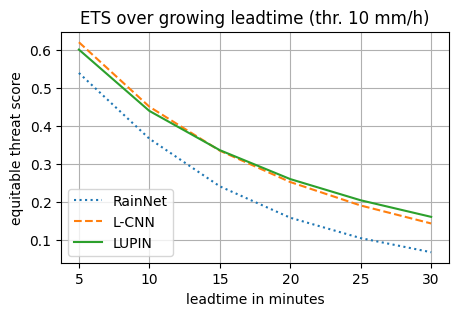

In [27]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, ets_dict['RainNet'], ':', label='RainNet')
plt.plot(x, ets_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, ets_dict['LUPIN'], label='LUPIN')
#plt.plot(x, ets_dict['EuclidP'], label='Euclidean Persistence')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("equitable threat score")
plt.title('ETS over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("ets.pdf", bbox_inches='tight')

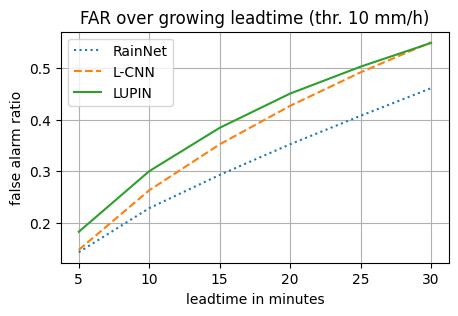

In [23]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, far_dict['RainNet'], ':', label='RainNet')
plt.plot(x, far_dict['L-CNN'], '--', label='L-CNN')
plt.plot(x, far_dict['LUPIN'], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("false alarm ratio")
plt.title('FAR over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="upper left")
plt.savefig("far.pdf", bbox_inches='tight')